In [7]:
from pandas import read_csv

import numpy as np

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
import matplotlib.pyplot as plt


In [8]:
def read_data(filepath):
    df = read_csv(filepath, header=None, names=['user-id',
                                               'activity',
                                               'timestamp',
                                               'X',
                                               'Y',
                                               'Z'])
    df['Z'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['Z'] = df['Z'].apply(convert_to_float)
#     df.dropna(axis=0, how='any', inplace=True)
    return df

def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

In [16]:
df = read_data('E:\Tim\sem 5\ML project\WISDM_ar_v1.1_raw.txt')
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098205,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098206,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098207,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


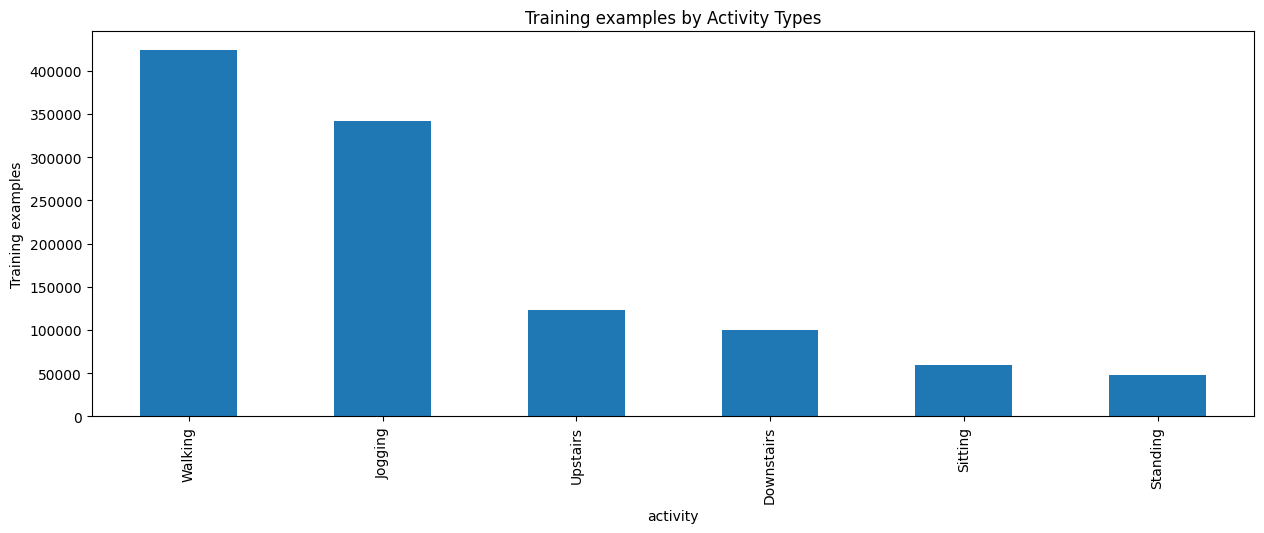

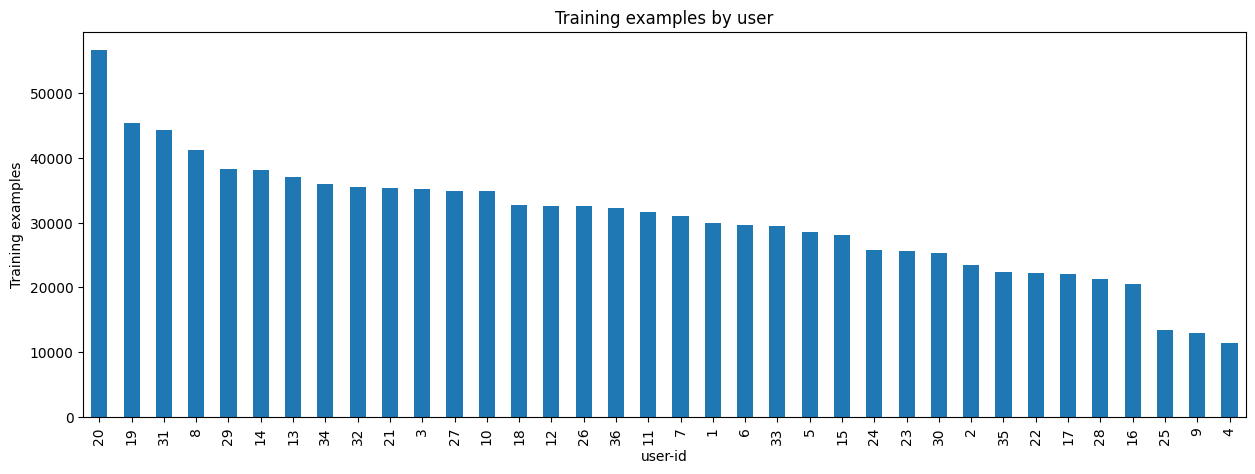

In [17]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

In [18]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

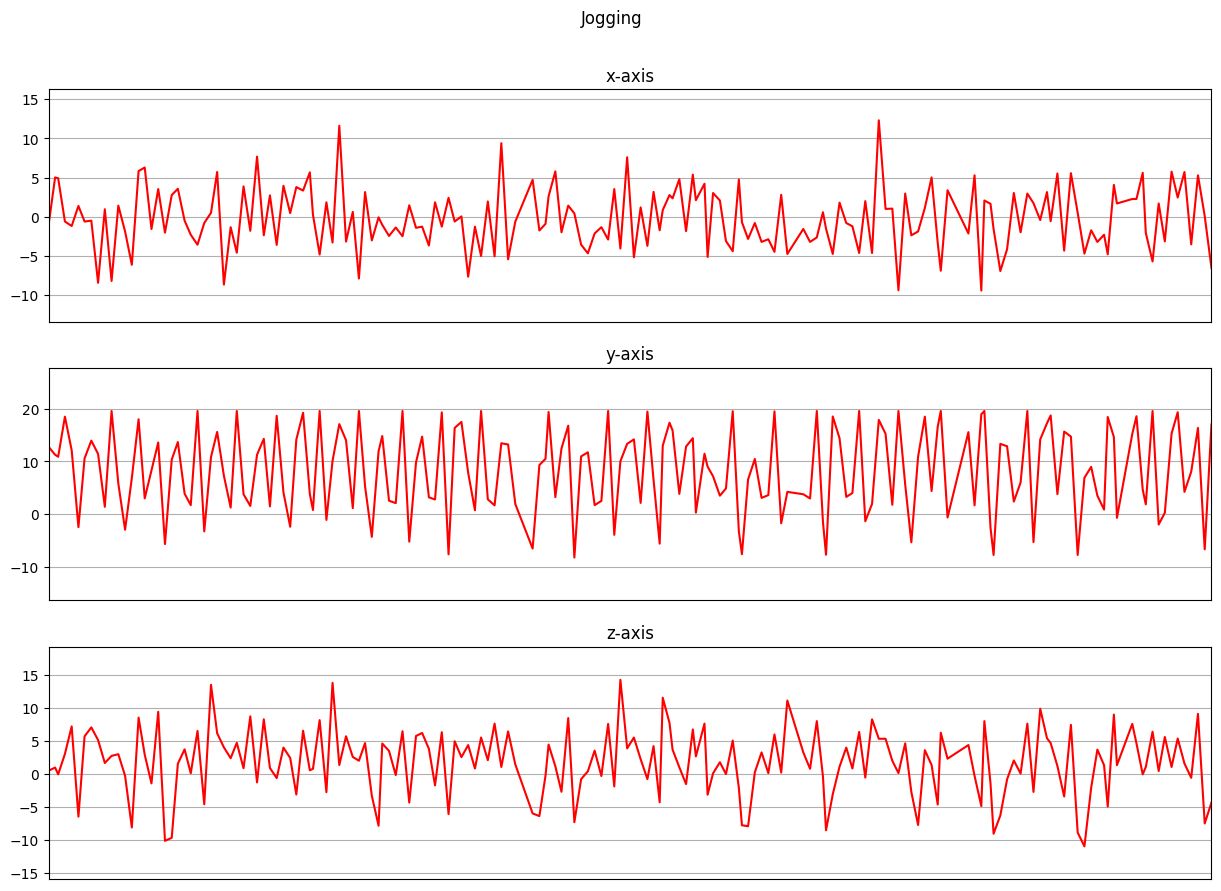

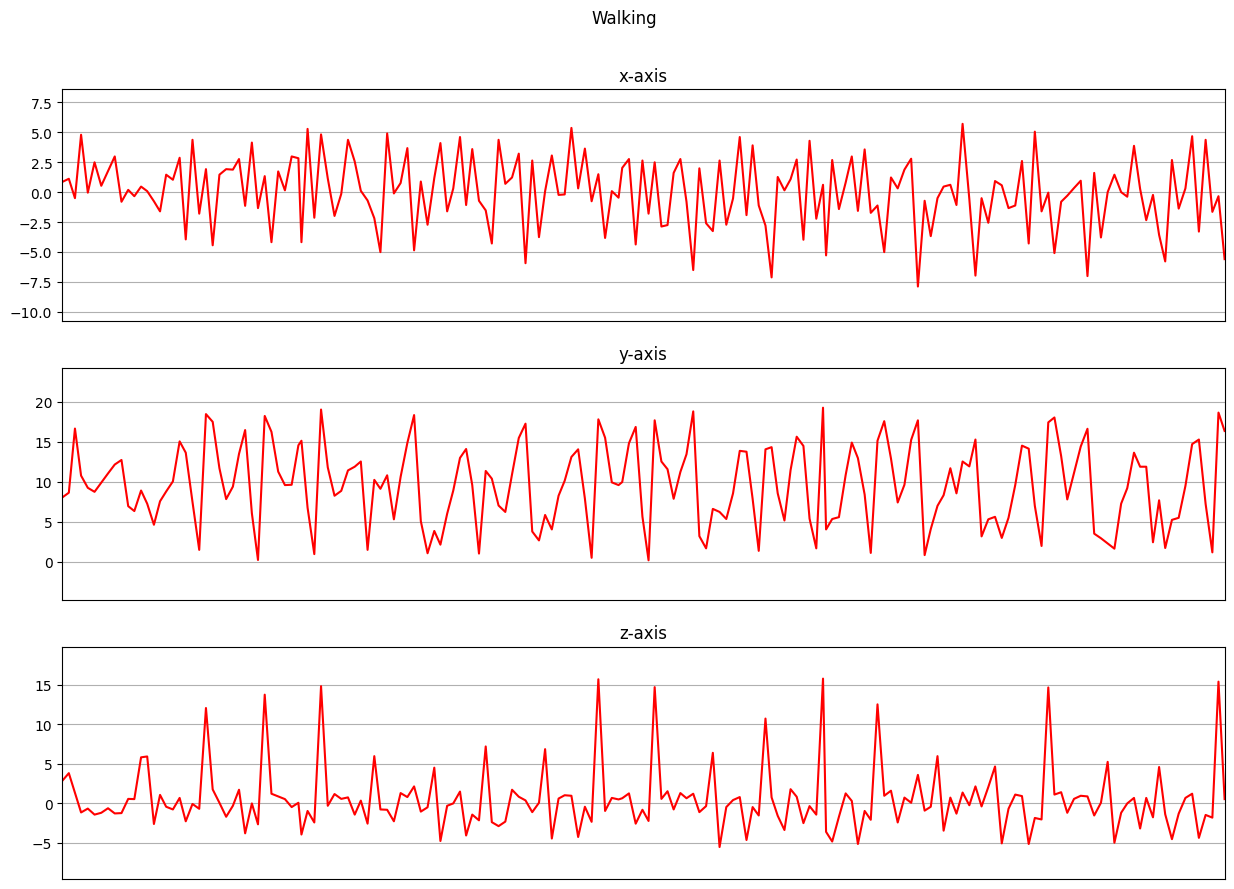

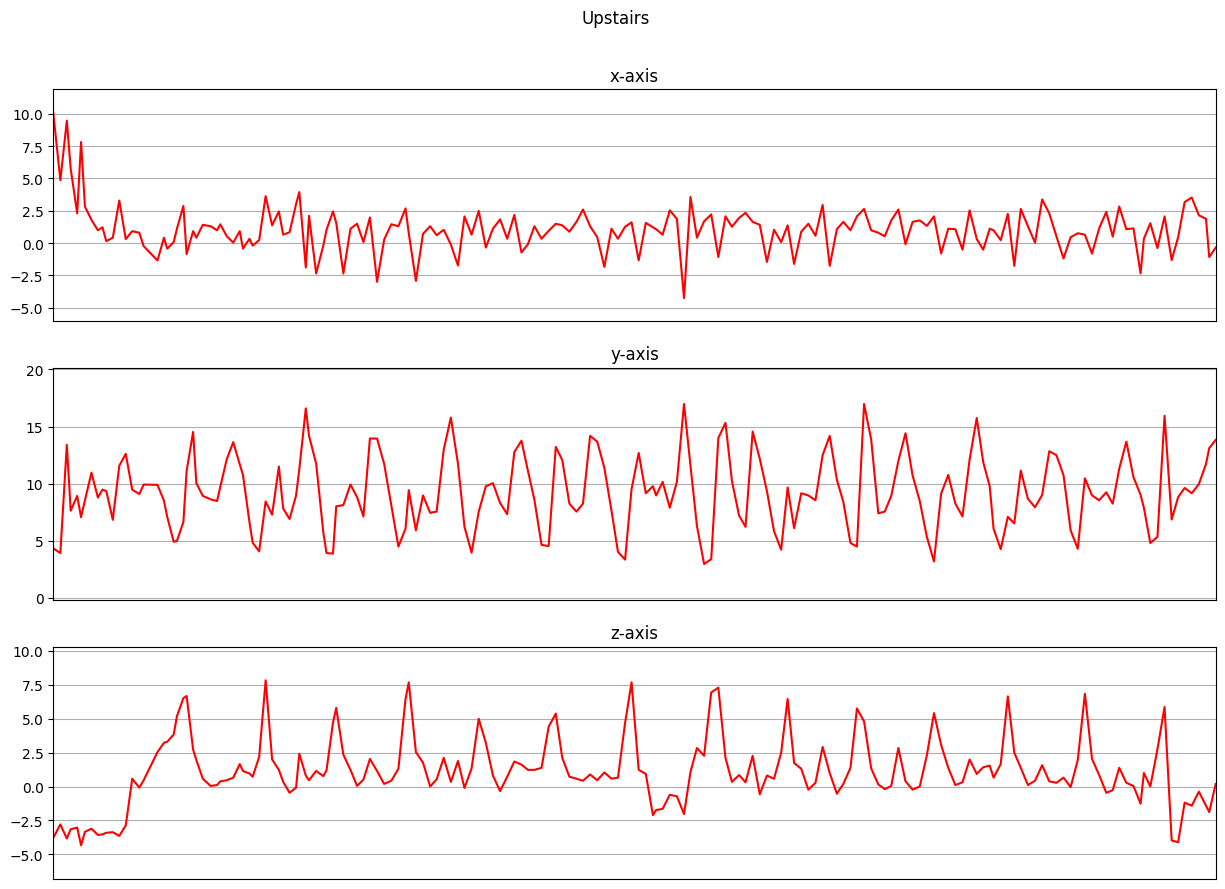

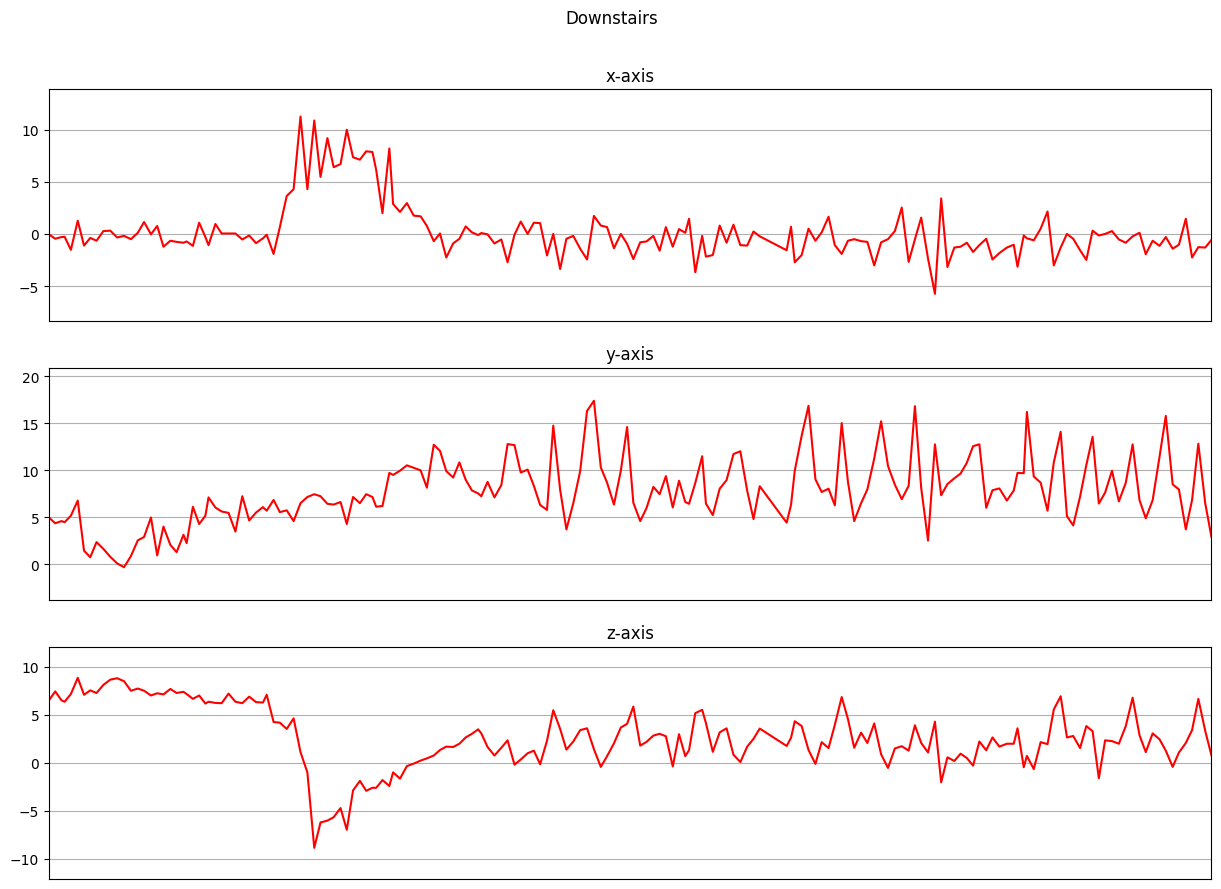

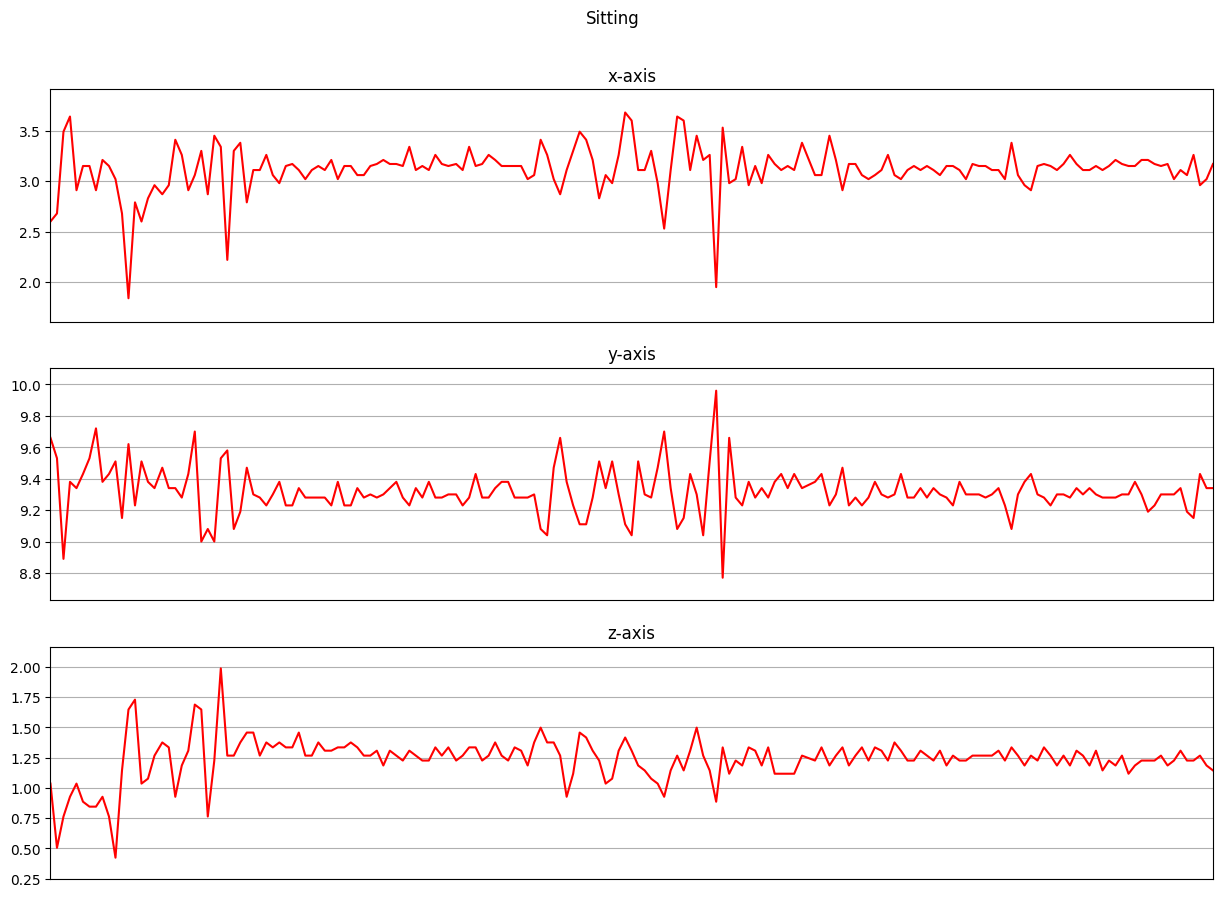

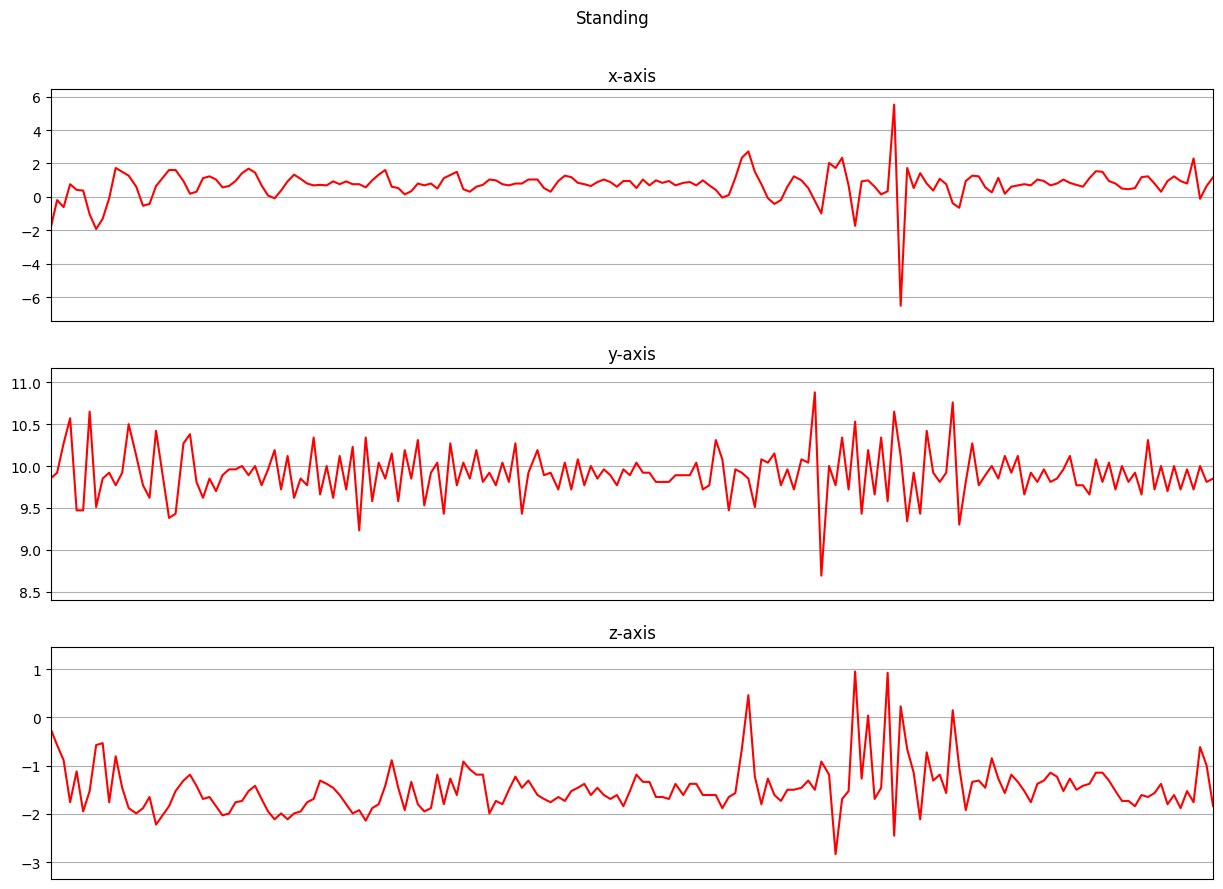

In [19]:
for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [20]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098205,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098206,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098207,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [21]:
df.isna().sum()

user-id           0
activity          0
timestamp         0
X                 0
Y                 0
Z                 1
activityEncode    0
dtype: int64

In [22]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
interpolation_fn

In [23]:
null_list = df[df['Z'].isnull()].index.tolist()
null_list

[343419]

In [24]:
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

4.75


In [25]:
df.isna().sum()

user-id           0
activity          0
timestamp         0
X                 0
Y                 0
Z                 0
activityEncode    0
dtype: int64

In [26]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [27]:
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098204,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098205,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098206,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098207,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


In [28]:
df_train['activityEncode'].value_counts()

activityEncode
5    314342
1    262654
4     90906
0     71436
2     41932
3     32157
Name: count, dtype: int64

In [29]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]
        
        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels

In [30]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [31]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (20334, 80, 3)
Training samples: 20334
y_train shape: (20334,)


In [32]:
## Input and Output Dimensions
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [33]:
## reshaping data
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  240
Input Data Shape:  (20334, 240)


In [34]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [35]:
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)

y_train shape:  (20334, 6)


In [36]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model.add(LSTM(32,return_sequences=True, activation='relu'))
model.add(Reshape((1, 240, 32)))
model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model.add(Reshape((120, 64)))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(Reshape((29, 192)))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(6))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 240, 32)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 240, 32)           8320      
                                                                 
 reshape (Reshape)           (None, 1, 240, 32)        0         
                                                                 
 conv1d (Conv1D)             (None, 1, 120, 64)        4160      
                                                                 
 reshape_1 (Reshape)         (None, 120, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 30, 64)            0         
 D)                                                              
                                                        

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
history = model.fit(x_train,
                    y_train_hot, 
                    batch_size= 192, 
                    epochs=100
                   )

Epoch 1/100
106/106 [==============================] - 44s 385ms/step - loss: 0.8746 - accuracy: 0.7042
Epoch 2/100
106/106 [==============================] - 42s 395ms/step - loss: 0.5394 - accuracy: 0.7935
Epoch 3/100
106/106 [==============================] - 35s 326ms/step - loss: 0.4733 - accuracy: 0.8202
Epoch 4/100
106/106 [==============================] - 35s 333ms/step - loss: 0.4096 - accuracy: 0.8507
Epoch 5/100
106/106 [==============================] - 35s 330ms/step - loss: 0.3651 - accuracy: 0.8651
Epoch 6/100
106/106 [==============================] - 35s 330ms/step - loss: 0.3339 - accuracy: 0.8755
Epoch 7/100
106/106 [==============================] - 35s 327ms/step - loss: 0.3139 - accuracy: 0.8836
Epoch 8/100
106/106 [==============================] - 35s 328ms/step - loss: 0.2927 - accuracy: 0.8910
Epoch 9/100
106/106 [==============================] - 37s 345ms/step - loss: 0.2893 - accuracy: 0.8918
Epoch 10/100
106/106 [==============================] - 38s 362m

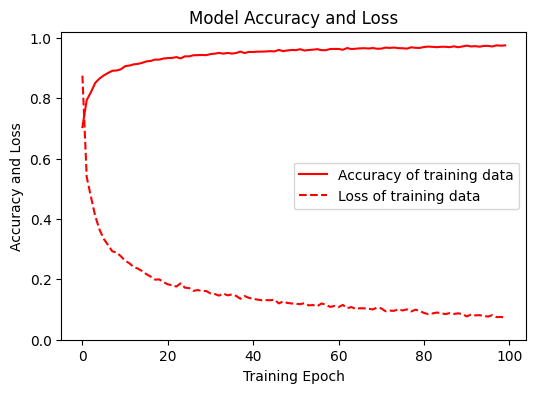

636/636 [==============================] - 15s 24ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1788
         1.0       0.72      1.00      0.84      6568
         2.0       0.32      1.00      0.49      1050
         3.0       0.00      0.00      0.00       802
         4.0       0.96      0.18      0.31      2271
         5.0       0.99      0.95      0.97      7855

    accuracy                           0.76     20334
   macro avg       0.50      0.52      0.43     20334
weighted avg       0.74      0.76      0.70     20334



In [39]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_train = model.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [40]:
df_test['X'] = (df_test['X']-df_test['X'].min())/(df_test['X'].max()-df_test['X'].min())
df_test['Y'] = (df_test['Y']-df_test['Y'].min())/(df_test['Y'].max()-df_test['Y'].min())
df_test['Z'] = (df_test['Z']-df_test['Z'].min())/(df_test['Z'].max()-df_test['Z'].min())
df_test

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,0.478144,0.820181,0.528758,1
1,33,Jogging,49106062271000,0.622404,0.784202,0.540574,1
2,33,Jogging,49106112167000,0.619649,0.774515,0.513362,1
3,33,Jogging,49106222305000,0.480209,0.967905,0.594998,1
4,33,Jogging,49106332290000,0.465749,0.805651,0.704920,1
...,...,...,...,...,...,...,...
832897,31,Standing,25207361641000,0.702983,0.612903,0.519453,3
832898,31,Standing,25207401497000,0.722194,0.600203,0.553891,3
832899,31,Standing,25207441536000,0.697169,0.618745,0.531546,3
832900,31,Standing,25207521553000,0.698180,0.619761,0.533649,3


In [41]:
x_test, y_test = segments(df_test,
                         TIME_PERIOD,
                         STEP_DISTANCE,
                         LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

In [42]:
score = model.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])

223/223 [==============================] - 6s 24ms/step - loss: 2.9132 - accuracy: 0.6833
Accuracy: 0.6833380460739136
Loss: 2.9131691455841064


223/223 [==============================] - 5s 24ms/step


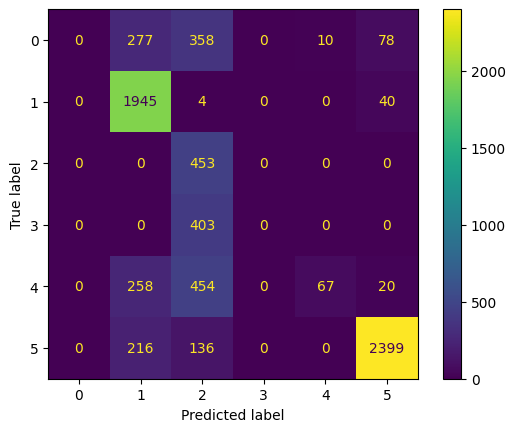

In [43]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()

In [45]:
predictions

array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [44]:
print(classification_report(y_test_pred, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       723
           1       0.72      0.98      0.83      1989
           2       0.25      1.00      0.40       453
           3       0.00      0.00      0.00       403
           4       0.87      0.08      0.15       799
           5       0.95      0.87      0.91      2751

    accuracy                           0.68      7118
   macro avg       0.46      0.49      0.38      7118
weighted avg       0.68      0.68      0.63      7118



In [1]:
import cv2